https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html
    
Approach: 
Predict price using food type, store location, and store brand.

Outcome variable: Price

Predictors: food type, store location, store brand

P(x|food, location, store) = N(food | mean, sd) * N(location | mean, sd) * N(store | ) 

Only three products per food could be reported in the survey. Thus, in the case where a store sold more than 3 products for one type of food, only a subset of products could be reported in the survey. We make the assumption that the products chosen were chosen at random. Accross all the students, this seems to be a plausible assumptions: even though individual students may have biases towards choosing e.g. cheaper products, I see no reason to believe these individual biases to be systematically correlated and thus should be okay on a per food basis as the number of students is large. However, for answering later questions where the number of students reporting is smaller, such as geographical relevance, individual bias may affect our affect our estimates.

Furthermore, if a store has a broad range of offerings for every food, i.e. both cheap and expensive versions, taking the average for the store brand could paint a misleading picture. For example, if a store offers a more exclusive line of products alongside cheaper brands offered at all stores, that would drag the base price multiplier up indicating that it is more expensive store. This could indicate that the store is not a good place to go if one cares about getting cheap food. In reality, however, it is just as cheap as other stores - but it also offers the alternative to buy more exclusive products should one want!

In [256]:
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [310]:
df = pd.read_csv("/Users/oscarengelbrektson/Downloads/CS146 LBA data gathering (Fall 2019) (Responses) - Form Responses 1 (2).csv",
                header=1)

In [306]:
df.head()

,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Product 1 quantity (kg),Product 1 price (€),Product 2 quantity (kg),Product 2 price (€),Product 3 quantity (kg),...,Product 2 quantity (count),Product 2 price (€).8,Product 3 quantity (count),Product 3 price (€).8,Product 1 quantity (kg).7,Product 1 price (€).9,Product 2 quantity (kg).7,Product 2 price (€).9,Product 3 quantity (kg).7,Product 3 price (€).9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/28/2019 13:14:59,brian.swanberg@minerva.kgi.edu,Brian Swanberg,ALDI,Rummelsburger Str. 98,0.88,2.20,1.0,1.88,0.6,...,6.0,1.59,10.0,1.59,0.6,3.99,1.0,5.99,NaN,NaN
2,10/29/2019 14:19:19,emma.stiefel@minerva.kgi.edu,Emma Stiefel,REWE,Karl-Marx-Straße 92-98,1.00,2.49,1.0,1.49,1.0,...,1.0,0.25,6.0,1.59,1.0,13.90,1.0,9.99,1.0,9.98
3,"10/29/2019 21:22:30,taha@minerva.kgi.edu,Taha,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"10/30/2019 16:20:11,michaelchen@minerva.kgi.ed...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# What is the basic average price for each product? 

In the data submission questionnaire, the unit of price (currency) was specified for each product. Given that the 3 currencies represented in m20 and m21 rotations–GBP, EUR and USD–are all similar in value, there is no way to know whether an unusual price is based on incorrect currency specification or a specific store/location being priced that way. Consequently, I will proceed on the assumption that data were correctly reported by my classmates, and thus that all prices were reported in EUR.

Approach to getting the prices for each food:
Goal: For each product, a list of all recorded prices for one unit of the product.
1. For every product, normalize price by quanitity so as to get price/1unit.
2. For every food, make a list of all product prices.

After this, we are ready perform bayesian inference to derive the average price for each product.

### 1. Normalizing price by quanitity
The unit of quantity was specified for each product. The estimation of base price then, will be expressed on a per unit basis. For example, the estimated base price of bananas will be expressed on a per kilo basis. To achieve this, we begin by normalizing each product price by the product quantity. For example, Brian reported that 0.88kg's of apples sold at a price of €2.2, we calculate 2.2/0.88 to get price/kg. In the case where the reported quantity is 1, this will have no effect.


Starting on the 5th column, all subsequent columns are quantity-price pairs. That is, all odd columns will represent quantities, and the column just after will represent the corresponding price. We use this to iterate over the columns and rows with columns, dividing price/quantity.

We then drop the quantity columns as all prices will be expressed in terms of one unit of quantity, meaning they no longer have any value.

In [284]:
quantity_col_indexes = list(range(5, len(df.columns), 2))
for i in quantity_col_indexes:
    df.iloc[:,i+1] = df.iloc[:,i+1]/df.iloc[:,i]

#Drop quantity columns
#df.drop(df.columns[quantity_col_indexes], axis=1, inplace=True)

### 2. Making a list of product prices for each food

We know that each food now has three product columns each with price/unit. The first food is in column 5. We use this to create a list of prices for each food.
If an entry is Nan, we omit it as it represents product that does not exist.

In [285]:
foods = ["Apples", "Bananas", "Tomatoes", "Potatoes", "Flour, white", 
         "Rice, basmati", "Milk, full cream", "Butter", "Eggs", "Chicken breasts"]

food_prices = {}
for i in range(len(foods)):
    #get prices for each food product
    prices = df.iloc[:,5+3*i:5+3*i+3].values.flatten()
    
    #Remove nan entries and add to dictionary
    food_prices[foods[i]] = prices[~np.isnan(prices)]

In [308]:
print(len(dataset["price"].loc[dataset["food"]=="Apples"]))
len(food_prices["Apples"])

72


72

In [312]:
len(dataset)

649

(array([18., 14., 22.,  6.,  4.,  3.,  0.,  2.,  2.,  1.]),
 array([1.145     , 1.78633333, 2.42766667, 3.069     , 3.71033333,
        4.35166667, 4.993     , 5.63433333, 6.27566667, 6.917     ,
        7.55833333]),
 <a list of 10 Patch objects>)

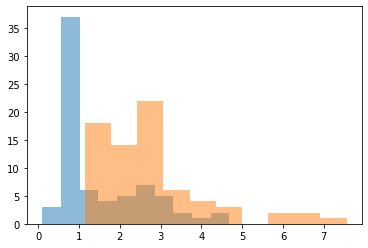

In [298]:
plt.hist(food_prices["Apples"], alpha=0.5)
plt.hist(dataset["price"].loc[dataset["food"]=="Apples"], alpha=0.5)

In [313]:
prices, foods, locations, stores = [], [], [], []
col_to_food = {5:"Apples", 11:"Bananas", 17:"Tomatoes", 23:"Potatoes", 29:"Flour, white", 
         35:"Rice, basmati", 41:"Milk, full cream", 47:"Butter", 53:"Eggs", 59:"Chicken breasts"}

quantity_col_indexes = list(range(5, len(df.columns), 6))
for i in quantity_col_indexes:
    food = col_to_food[i]
    
    for row in range(len(df)):
        location = df.iloc[row, 4]
        store = df.iloc[row, 3]
        
        #3 products for every food
        for j in range(0, 6, 2):
            
            normalized_price = df.iloc[row, i+j+1]/df.iloc[row, i+j]
            
            #Record values
            if not np.isnan(normalized_price):
                prices.append(normalized_price)
                foods.append(food)
                locations.append(location)
                stores.append(store)
            
#Combine lists onto pandas dataframe
dataset = pd.DataFrame()
dataset["price"] = prices
dataset["food"] = foods
dataset["location"] = locations
dataset["store"] = stores

#Step 5, drop non-observations
#dataset.dropna()

dataset.head()

,price,food,location,store
0,2.50,Apples,Rummelsburger Str. 98,ALDI
1,1.88,Apples,Rummelsburger Str. 98,ALDI
2,3.15,Apples,Rummelsburger Str. 98,ALDI
3,2.49,Apples,Karl-Marx-Straße 92-98,REWE
4,1.49,Apples,Karl-Marx-Straße 92-98,REWE


## Modelling the base price of each food

Gamma for prior.

In [214]:
stan_code = """
data {  
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
    int<lower=1> n_obs;
    real<lower=0> prices[n_obs]; // waiting time data
    real<lower=0> sigma;
}

parameters {
    real<lower=0> mu;
}
model {
    mu ~ gamma(alpha, beta);  // prior over lambda
    prices ~ lognormal(mu, sigma);
}
"""

In [215]:
#Compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16cff785b2b10328ffcab5903116e4ab NOW.


In [216]:
data = {
    "alpha": 1.5,  # fixed prior hyperparameters for the
    "beta": 1,   # gamma distribution
    "sigma":1,
    "n_obs": len(food_prices["Apples"]),
    "prices": food_prices["Apples"],  # waiting time data
}

In [217]:
#Sample posterior distribution over lambda
stan_results = stan_model.sampling(data = data)

In [218]:
#Estimate porterior 98% confidence interval over lambda using Stan
print(stan_results.stansummary(pars=['mu'], probs=[0.025, 0.975]))

Inference for Stan model: anon_model_16cff785b2b10328ffcab5903116e4ab.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
mu   0.88  2.0e-3   0.07   0.74   1.01   1181    1.0

Samples were drawn using NUTS at Sun Nov  3 13:40:34 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(array([0.02327602, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04655204, 0.06982805, 0.13965611, 0.23276018,
        0.37241629, 0.37241629, 0.53534842, 0.53534842, 0.90776471,
        1.37328507, 1.62932127, 2.49053394, 2.60691404, 2.49053394,
        4.02675114, 3.65433485, 4.77158373, 5.3767602 , 5.42331223,
        5.42331223, 5.44658825, 5.72590047, 5.81900454, 4.81813576,
        5.120724  , 4.0965792 , 3.74743893, 3.02588236, 2.67674209,
        1.90863349, 2.35087784, 1.7922534 , 1.46638915, 1.18707693,
        0.5120724 , 0.2560362 , 0.23276018, 0.13965611, 0.11638009,
        0.06982805, 0.02327602, 0.02327602, 0.02327602, 0.02327602]),
 array([0.59079207, 0.60153274, 0.61227341, 0.62301408, 0.63375475,
        0.64449542, 0.65523608, 0.66597675, 0.67671742, 0.68745809,
        0.69819876, 0.70893943, 0.7196801 , 0.73042076, 0.74116143,
        0.7519021 , 0.76264277, 0.77338344, 0.78412411, 0.79486478,
        0.80560545, 0.81634611, 0.82708678, 0.

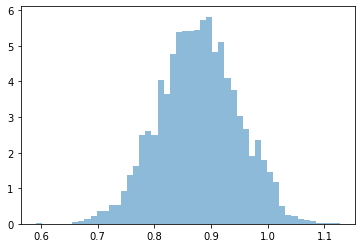

In [219]:
# Posterior samples from Stan
posterior_samples = stan_results.extract()

#For the stan samples
plt.hist(posterior_samples['mu'], 
         bins=50, density=True, alpha=0.5, label='Stan')
plt.hist()

In [ ]:
x=np.linspace(0, 15, 4000)
norms = sts.norm(posterior_samples['mu'],posterior_samples['sigma']).pdf(x)

In [ ]:
#Sampling the posterior distribution over our parameters using Stan
mu_samples = stan_results.extract()['mu']
sigma2_samples = stan_results.extract()['sigma']

#Draw 10 random samples from the set of samples.
import random
n_samples = 10
mu_10 = np.random.choice(mu_samples, n_samples)
sigma2_10 = np.random.choice(sigma2_samples, n_samples)

#Plot each parameter sample pair
plt.figure(figsize=(10, 8))
x = np.linspace(0, 15, 1000)
for i in range(n_samples):
           y = sts.norm.pdf(x, loc=mu_10[i], scale=(sigma2_10[i]))
           plt.plot(x, y)
plt.title("10 normal distributions with parameters sigma and mu sampled from the posterior distribution")
plt.ylabel("Density")
plt.xlabel("x")
plt.show()

In [190]:
mu_samples.mean()

0.519000830556013

(array([ 3., 27., 48., 54., 22., 15., 11.,  4.,  4.,  3.,  1.,  3.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  2.]),
 array([ 0.359375  ,  0.92072917,  1.48208333,  2.0434375 ,  2.60479167,
         3.16614583,  3.7275    ,  4.28885417,  4.85020833,  5.4115625 ,
         5.97291667,  6.53427083,  7.095625  ,  7.65697917,  8.21833333,
         8.7796875 ,  9.34104167,  9.90239583, 10.46375   , 11.02510417,
        11.58645833, 12.1478125 , 12.70916667, 13.27052083, 13.831875  ,
        14.39322917, 14.95458333, 15.5159375 , 16.07729167, 16.63864583,
        17.2       ]),
 <a list of 30 Patch objects>)

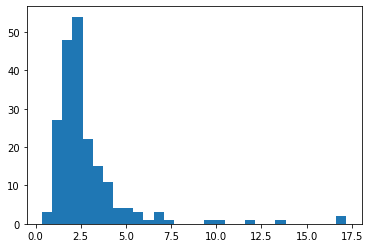

In [222]:
plt.hist(food_prices["Apples"], bins=30)